# TD9 : Analyse discriminante de données gaussiennes

## 1. Partie pratique

### Visualisation des jeux de données

In [4]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

[]

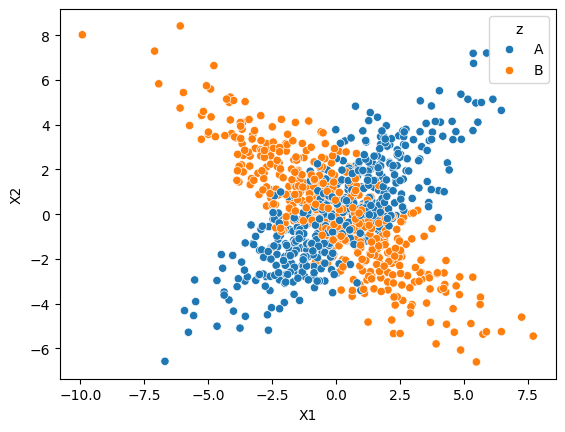

In [5]:
synthcross = pd.read_csv("data/SynthCross_n1000_p2.csv")

sns.scatterplot(data=synthcross, x="X1", y="X2", hue="z")
plt.plot()

[]

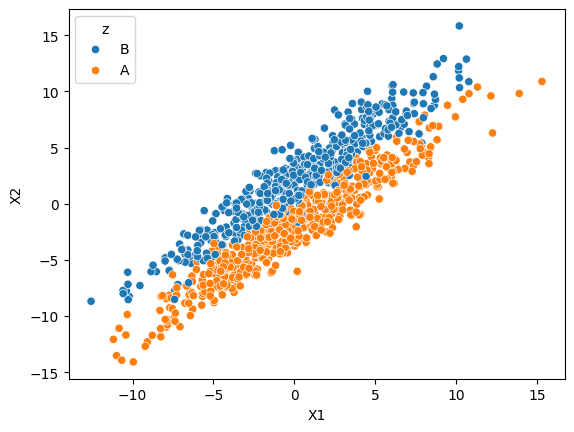

In [6]:
synthpara = pd.read_csv("data/SynthPara_n1000_p2.csv")

sns.scatterplot(data=synthpara, x="X1", y="X2", hue="z")
plt.plot()

[]

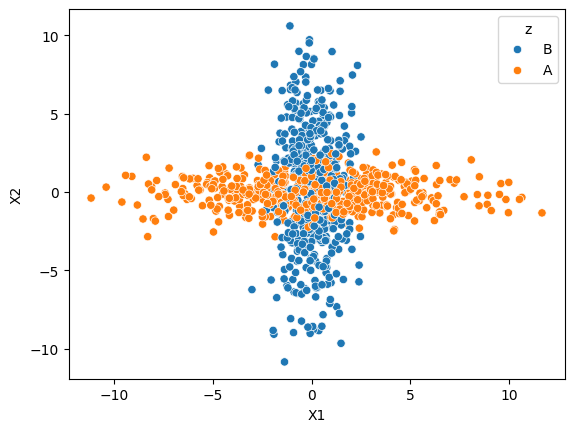

In [7]:
synthplus = pd.read_csv("data/SynthPlus_n1000_p2.csv")

sns.scatterplot(data=synthplus, x="X1", y="X2", hue="z")
plt.plot()

### Erreurs de validation des modèles

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [41]:
def validation_errors(X, y, models : dict):
    for model_name, model in models.items():
        val_scores = cross_val_score(model, X, y, cv = 10)
        for index, val_score in enumerate(val_scores):
            yield model_name, index, 1 - val_score

In [45]:
models = {
    "LDA" : LinearDiscriminantAnalysis(), 
    "QDA" : QuadraticDiscriminantAnalysis(),
    "NB" : GaussianNB()
}

In [46]:
val_errors = []


for name, dataset in zip(["SynthPara", "SynthCross", "SynthPlus"], [synthpara, synthcross, synthplus]):
    for model_name, index, error in validation_errors(dataset[["X1", "X2"]], dataset[["z"]], models=models):
        val_errors.append({"name_dataset" : name, "model_name" : model_name, "fold" : index, "validation_error" : error})


val_errors_df = pd.DataFrame(data = val_errors)
val_errors_df

,name_dataset,model_name,fold,validation_error
0,SynthPara,LDA,0,0.05
1,SynthPara,LDA,1,0.07
2,SynthPara,LDA,2,0.08
3,SynthPara,LDA,3,0.11
4,SynthPara,LDA,4,0.04
...,...,...,...,...
85,SynthPlus,NB,5,0.15
86,SynthPlus,NB,6,0.10
87,SynthPlus,NB,7,0.17
88,SynthPlus,NB,8,0.16


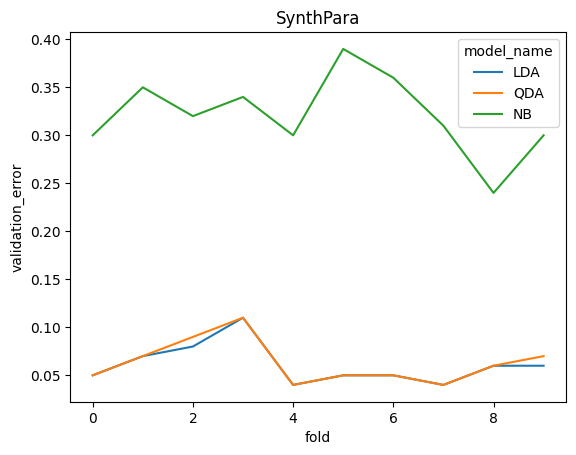

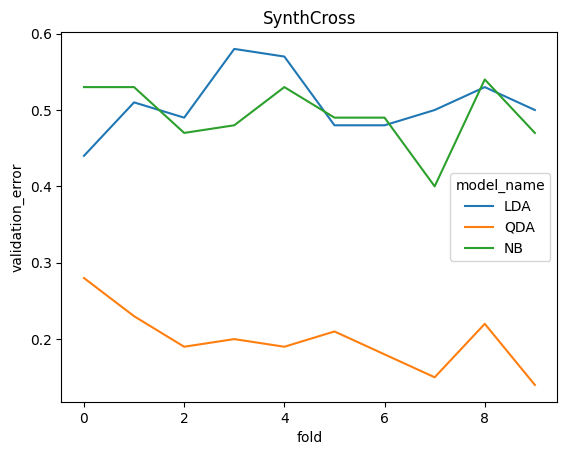

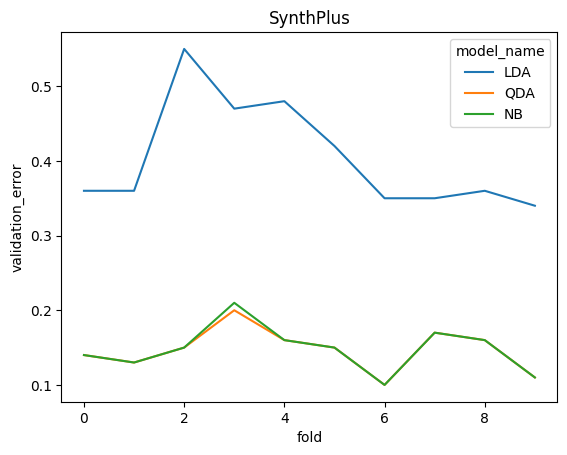

In [47]:
for dataset_name in val_errors_df["name_dataset"].unique():
    fig = plt.figure()
    df = val_errors_df[val_errors_df["name_dataset"] == dataset_name]
    sns.lineplot(data = df, x = "fold", y = "validation_error", hue = "model_name").set(title = f"{dataset_name}")
    plt.plot()

### Matrices de covariances des données

In [54]:
synthcross_cov = np.cov(synthcross[["X1", "X2"]].T.to_numpy())
synthcross_cov

array([[ 5.23623017, -0.58726973],
       [-0.58726973,  5.3323873 ]])

In [55]:
synthpara_cov = np.cov(synthpara[["X1", "X2"]].T.to_numpy())
synthpara_cov

array([[19.24776459, 18.5840513 ],
       [18.5840513 , 23.80993787]])

In [56]:
synthplus_cov = np.cov(synthplus[["X1", "X2"]].T.to_numpy())
synthplus_cov

array([[ 8.17344552, -0.07483007],
       [-0.07483007,  7.92531733]])

## Jeux de données de dimension p = 300

In [58]:
from scipy.stats import norm
from scipy import linalg
from sklearn.decomposition import PCA

def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """Diagramme de dispersion dans le premier plan principal.

    Permet d'afficher un diagramme de dispersion lorsque les données
    ont plus de deux dimensions. L'argument `columns` spécifie la
    liste des colonnes à utiliser pour la PCA dans le jeu de données
    `data`. Les arguments `style` et `hue` permettent de spécifier la
    forme et la couleur des marqueurs. Les arguments `pc1` et `pc2`
    permettent de sélectionner les composantes principales (par défaut
    la première et deuxième). Retourne l'objet `Axes` ainsi que le
    modèle `PCA` utilisé pour réduire la dimension.

    :param columns: Les colonnes quantitatives de `data` à utiliser
    :param hue: La colonne de coloration
    :param style: La colonne du style
    :param data: Le dataFrame Pandas
    :param pc1: La composante en abscisse
    :param pc2: La composante en ordonnée

    """
     # Select relevant columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions if needed
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **kwargs)

    return ax, pca

In [ ]:
synthcross = pd.read_csv("data/SynthCross_n1000_p300.csv.gz")

sns.scatterplot_pca(data=synthcross, x="X1", y="X2", hue="z")
plt.plot()